# Load modules

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../data/house"))

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']


# Load data

In [2]:
df_train = pd.read_csv("../data/raw/house/train.csv")
df_test = pd.read_csv("../data/raw/house/test.csv")
df_train['MlUse'] = 'train'
df_test['MlUse'] = 'test'
df = pd.concat([df_train, df_test], axis=0)

In [3]:
# Id, MlUse 필드 빼면 80개 필드
df.sample(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
373   1834          70       RM          NaN     5775   Pave   NaN      IR2   
867    868          20       RL         85.0     6970   Pave   NaN      Reg   
1214  2675         120       RL         43.0     3010   Pave   NaN      Reg   

     LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold  \
373          Bnk    AllPub  ...    NaN   NaN         NaN       0      2   
867          Lvl    AllPub  ...    NaN   NaN        Shed     400      5   
1214         Lvl    AllPub  ...    NaN   NaN         NaN       0      6   

     YrSold SaleType  SaleCondition  SalePrice  MlUse  
373    2009       WD         Normal        NaN   test  
867    2007       WD         Normal   129000.0  train  
1214   2006      New        Partial        NaN   test  

[3 rows x 82 columns]

In [4]:
# train: (1460, 81), test: (1459, 80)
print("Shape train: {tr_shape}, test: {te_shape}".format(
                    tr_shape=df[df['MlUse']=='train'].shape, te_shape=df[df['MlUse']=='test'].shape))

Shape train: (1460, 82), test: (1459, 82)


In [5]:
df.describe() # numeric은 80개 필드 중, 38개

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235  ...   
std       1.113131    30.291442     20.894344   179.334253   455.610826  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean     93.709832    47.486811      23.098321     2.602261    16.062350   
std     126.526589    67.575493      64.244246    25.188169    56.184365   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2919.000000   2919.000000  2919.000000  2919.000000    1460.000000  
mean      2.251799     50.825968     6.213087  2007.792737  180921.195890  
std      35.663946    567.402211     2.714762     1.314964   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

# data profiling

## data type 체크

In [6]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/yIS4o.png", width=400, height=400)

## numeric data profiling

In [7]:
# numeric 타입들을 리스트화
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#newdf = df_train.select_dtypes(include=numerics).sample(frac=0.1)
temp_numeric_df = df.select_dtypes(include=np.number).sample(frac=0.1) # 같은 결과 코드
temp_numeric_df.head(3) # id 제외하면, 37개 필드
#list(newdf.columns.values)

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
975   2436          20         70.0     7000            5            6   
757   2218          70         60.0     5280            4            7   
1172  2633         120         60.0     8147            9            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  \
975        1961          1961         0.0         0.0  ...           0   
757        1895          1950         0.0         0.0  ...           0   
1172       2005          2005       230.0      1191.0  ...         156   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
975             0              0          0            0         0        0   
757           123              0          0            0         0        0   
1172           55              0          0            0         0        0   

      MoSold  YrSold  SalePrice  
975        7    2007        NaN  
757        7    2008        NaN  
1172       8    2006        NaN  

[3 rows x 38 columns]

In [8]:
from pandas_profiling import ProfileReport

In [9]:
# 292개 row, 39개 필드에 2분 걸림
profile = ProfileReport(temp_numeric_df, 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_data.html")

In [10]:
Image(url= "data_profile/profile_numeric_data.png", width=900)

### profile html 에서, SalePrice로 다른 필드들 값과 scatter로 interaction 파트 보면, 피쳐 전략이 나옴..
* outlier도 눈에 보임
* skew가 너무 강한 필드도 보임
* squeezing 해야 하는 필드도 보임 (max값이 너무 동떨어진 경우)

In [11]:
# 더이상 필요없으니 없애자
numeric_feats = list(temp_numeric_df.columns.values)
del temp_numeric_df

## categorical data profiling

In [12]:
temp_categorical_df = df.select_dtypes(exclude=np.number).sample(frac=0.1) 
temp_categorical_df.head(3) # MlUse 빼고, 43개 필드
#list(temp_categorical_df.columns.values)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
876        RL   Pave   NaN      Reg         HLS    AllPub    Inside       Mod   
1199       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
1082       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1  ... GarageFinish GarageQual GarageCond  \
876       Mitchel       Norm  ...          Unf         TA         TA   
1199      NridgHt       Norm  ...          Fin         TA         TA   
1082      CollgCr       Norm  ...          RFn         TA         TA   

     PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  MlUse  
876           Y    NaN   NaN         NaN       WD        Normal  train  
1199          Y    NaN   NaN         NaN      New       Partial   test  
1082          Y    NaN   NaN         NaN       WD        Normal  train  

[3 rows x 44 columns]

In [13]:
# 146개 row, 44개 필드에 21초 걸림 (문자열 데이터는 금방 걸리는군..)
profile = ProfileReport(temp_categorical_df, 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_categorical_data.html")

In [14]:
Image(url= "data_profile/profile_categorical_data.png", width=900)

In [15]:
# 더이상 필요없으니 없애자
categorical_feats = list(temp_categorical_df.columns.values)
del temp_categorical_df

# 피쳐 엔지니어링

## y값 체크

In [16]:
import warnings
warnings.filterwarnings('ignore')

width=6.0, height=4.0


Text(0.5, 1.0, 'log transform SalePrice histogram')

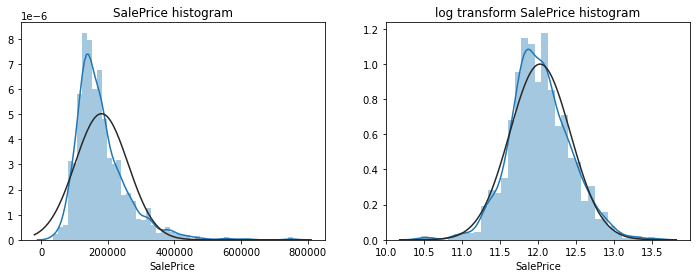

In [17]:
from scipy import stats                                                         

fig, ax = plt.subplots(1,2) # row 1개, column 2개
width, height = fig.get_size_inches()
print('width={w}, height={h}'.format(w=width,h=height))
fig.set_size_inches(width*2, height)
sns.distplot(df[df['MlUse']=='train']['SalePrice'], ax=ax[0], fit=norm).set_title('SalePrice histogram')
sns.distplot(np.log1p(df[df['MlUse']=='train']["SalePrice"]), ax=ax[1], fit=norm).set_title('log transform SalePrice histogram')
# log 변환하면, norm dist에 가까워짐!

### 가장 중요한 SalePrice를 log 변환

In [18]:
df.loc[df['MlUse']=='train',"SalePrice"] = np.log1p(df[df['MlUse']=='train']["SalePrice"])

Text(0.5, 1.0, 'log-transformed SalePrice histogram')

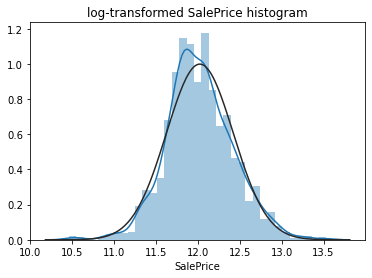

In [19]:
sns.distplot(df[df['MlUse']=='train']["SalePrice"], fit=norm).set_title('log-transformed SalePrice histogram')

## Constant (여러 값들로 채워져 있지 않은 필드) 필드 drop 하기

In [20]:
# Utilities는 AllPub이라는 값 외에는 없었으니 없애자
drop_feats = ['Street', 'Utilities', 'PoolQC']
df.drop(drop_feats, axis=1, inplace=True)

## 신규 필드 생성

In [21]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

## missing data 처리 필드 찾기

In [22]:
df_na = 100 * df.isnull().sum() / len(df)
display(df_na[1:4])

MSSubClass      0.000000
MSZoning        0.137033
LotFrontage    16.649538
dtype: float64

In [23]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True) # SalePrice 은 예외!
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(3) # missing이 80% 이상 데이터는 사용 불가능할듯. LotFrontage 데이터부터는 살려 볼 수 있을까?

Missing Ratio
MiscFeature      96.402878
Alley            93.216855
Fence            80.438506

In [24]:
# 필드 중에 대부분은 str이고, LotFrontage, GarageYrBlt 정도만 숫자 필드군..
right = pd.DataFrame(df.dtypes)
left = missing_data
left.join(right,how='left')

Missing Ratio        0
MiscFeature       96.402878   object
Alley             93.216855   object
Fence             80.438506   object
FireplaceQu       48.646797   object
LotFrontage       16.649538  float64
GarageFinish       5.447071   object
GarageYrBlt        5.447071  float64
GarageCond         5.447071   object
GarageQual         5.447071   object
GarageType         5.378554   object
BsmtCond           2.809181   object
BsmtExposure       2.809181   object
BsmtQual           2.774923   object
BsmtFinType2       2.740665   object
BsmtFinType1       2.706406   object
MasVnrType         0.822199   object
MasVnrArea         0.787941  float64
MSZoning           0.137033   object
Functional         0.068517   object
BsmtFullBath       0.068517  float64
BsmtHalfBath       0.068517  float64
KitchenQual        0.034258   object
Electrical         0.034258   object
TotalBsmtSF        0.034258  float64
GarageCars         0.034258  float64
GarageArea         0.034258  float64
BsmtUnfSF          0.034258  float64
BsmtFinSF2         0.034258  float64
BsmtFinSF1         0.034258  float64

## NA 변환 함수

In [25]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

## NA를 처리하자

In [26]:
# NA를 None 값으로 처리 (의미적 처리)
fill_missing(df, ["MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None")
# NA를 Unknown으로.
fill_missing(df, ['Electrical'], 'Unknown')
# NA를 0 으로 처리 (의미적 처리)
fill_missing(df, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
fill_missing_with_mode(df, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df, ["Functional"],"Typ")

In [27]:
df[["Functional","MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"]].head(3)

Functional MSZoning KitchenQual Exterior1st Exterior2nd SaleType
0        Typ       RL          Gd     VinylSd     VinylSd       WD
1        Typ       RL          TA     MetalSd     MetalSd       WD
2        Typ       RL          Gd     VinylSd     VinylSd       WD

In [28]:
df_na = 100 * df.isnull().sum() / len(df)

In [29]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True)
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data # LotFrontage 데이터 이후부터는 사용 불가일 듯...

Missing Ratio
LotFrontage      16.649538
TotalSF           0.034258

### LotFrontage의 missing ratio가 17%이긴 하지만, 좀 살려보자 (why? SalePrice와는 corr가 괜찮음)

In [30]:
# LotFrontage는 대략 21%가 NA였는데, 가장 비슷한 값을 넣어주려고, 이웃들의 LotFrontage의 가장 많은 값(median)을 넣어주자
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
                                            lambda x: x.fillna(x.median()))

### OverallQual 가 높아야 SalePrice 가 높아지는데, 
* OverallQual가 낮아도 SalePrice가 높은 row들은 제거하자
* GrLivArea가 높은데도, SalePrice가 낮은 row들도 제거하자

In [31]:
df.drop(df[(df['OverallQual']<5) & (df['SalePrice']>200000) & (df['MlUse']=='train')].index, inplace=True)
df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000) & (df['MlUse']=='train')].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [32]:
# 2919 --> 2911 (4개 row가 삭제)
df.shape

(2911, 80)

### 숫자 필드 중에, 카테고리성 필드가 있어서,
* 이들 필드는 카테고리로 형태 변환하자

In [33]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

### NA 다시 체크

In [34]:
df_na = 100 * df.isnull().sum() / len(df)
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True)
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data # LotFrontage 데이터 이후부터는 사용 불가일 듯...

Missing Ratio
TotalSF       0.034352

## 카테고리성 변수들의 처리

In [35]:
# 카테고리변수 필드 처리 --> 숫자 카테고리로 변환
# pd.factorize 를 사용하자... 
# https://www.geeksforgeeks.org/python-pandas-factorize/
from pandas.api.types import is_string_dtype


categorical_feats = [
        f for f in df.columns if (is_string_dtype(df[f]) and f!='MlUse')
]

print(categorical_feats)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


### pd.factorize를 이용한 encode

In [36]:
indexers = {} # map
for f_ in categorical_feats:
    df[f_], indexer = pd.factorize(df[f_])
    indexers[f_] = indexer

In [37]:
indexers

{'MSSubClass': Index(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
        '160', '75', '180', '40', '150'],
       dtype='object'),
 'MSZoning': Index(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype='object'),
 'Alley': Index(['None', 'Grvl', 'Pave'], dtype='object'),
 'LotShape': Index(['Reg', 'IR1', 'IR2', 'IR3'], dtype='object'),
 'LandContour': Index(['Lvl', 'Bnk', 'Low', 'HLS'], dtype='object'),
 'LotConfig': Index(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype='object'),
 'LandSlope': Index(['Gtl', 'Mod', 'Sev'], dtype='object'),
 'Neighborhood': Index(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
        'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW',
        'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr',
        'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'],
       dtype='object'),
 'Condition1': Index(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
     

In [38]:
df[categorical_feats].tail(5)

MSSubClass  MSZoning  Alley  LotShape  LandContour  LotConfig  \
2906          11         1      0         0            0          0   
2907          11         1      0         0            0          0   
2908           1         0      0         0            0          0   
2909           9         0      0         0            0          0   
2910           0         0      0         0            0          0   

      LandSlope  Neighborhood  Condition1  Condition2  ...  GarageFinish  \
2906          0            14           0           0  ...             3   
2907          0            14           0           0  ...             1   
2908          0             4           0           0  ...             1   
2909          0             4           0           0  ...             3   
2910          1             4           0           0  ...             2   

      GarageQual  GarageCond  PavedDrive  Fence  MiscFeature  MoSold  YrSold  \
2906           3           2           0      0            0      11       2   
2907           0           0           0      0            0       7       2   
2908           0           0           0      0            0       2       2   
2909           3           2           0      1            1       9       2   
2910           0           0           0      0            0       6       2   

      SaleType  SaleCondition  
2906         0              0  
2907         0              1  
2908         0              1  
2909         0              0  
2910         0              0  

[5 rows x 43 columns]

## SalePrice와 corr가 괜찮은 피쳐들에 대해서, 처리를 좀 더 해보자
* PolynomialFeatures 라는 피쳐 변환이 있다

In [39]:
correlated_feats = ['OverallQual', 'GrLivArea', 'GarageCars' , 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

In [40]:
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(df[correlated_feats])
poly_features = poly_transformer.transform(df[correlated_feats])


In [41]:
poly_features

array([[1.000000e+00, 7.000000e+00, 1.710000e+03, ..., 7.327360e+05,
        7.327360e+05, 7.327360e+05],
       [1.000000e+00, 6.000000e+00, 1.262000e+03, ..., 1.592644e+06,
        1.592644e+06, 1.592644e+06],
       [1.000000e+00, 7.000000e+00, 1.786000e+03, ..., 8.464000e+05,
        8.464000e+05, 8.464000e+05],
       ...,
       [1.000000e+00, 5.000000e+00, 1.224000e+03, ..., 1.498176e+06,
        1.498176e+06, 1.498176e+06],
       [1.000000e+00, 5.000000e+00, 9.700000e+02, ..., 8.317440e+05,
        8.846400e+05, 9.409000e+05],
       [1.000000e+00, 7.000000e+00, 2.000000e+03, ..., 9.920160e+05,
        9.920160e+05, 9.920160e+05]])

In [42]:
print(poly_transformer.get_feature_names(correlated_feats))

['1', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'OverallQual^2', 'OverallQual GrLivArea', 'OverallQual GarageCars', 'OverallQual GarageArea', 'OverallQual TotalBsmtSF', 'OverallQual 1stFlrSF', 'GrLivArea^2', 'GrLivArea GarageCars', 'GrLivArea GarageArea', 'GrLivArea TotalBsmtSF', 'GrLivArea 1stFlrSF', 'GarageCars^2', 'GarageCars GarageArea', 'GarageCars TotalBsmtSF', 'GarageCars 1stFlrSF', 'GarageArea^2', 'GarageArea TotalBsmtSF', 'GarageArea 1stFlrSF', 'TotalBsmtSF^2', 'TotalBsmtSF 1stFlrSF', '1stFlrSF^2']


In [43]:
df_poly_features = pd.DataFrame(poly_features,
                                columns=poly_transformer.get_feature_names(correlated_feats))
df_poly_features.drop(['1'], axis=1, inplace=True)
df_poly_features.drop(correlated_feats, axis=1, inplace=True)
df_poly_features.head(3)

OverallQual^2  OverallQual GrLivArea  OverallQual GarageCars  \
0           49.0                11970.0                    14.0   
1           36.0                 7572.0                    12.0   
2           49.0                12502.0                    14.0   

   OverallQual GarageArea  OverallQual TotalBsmtSF  OverallQual 1stFlrSF  \
0                  3836.0                   5992.0                5992.0   
1                  2760.0                   7572.0                7572.0   
2                  4256.0                   6440.0                6440.0   

   GrLivArea^2  GrLivArea GarageCars  GrLivArea GarageArea  \
0    2924100.0                3420.0              937080.0   
1    1592644.0                2524.0              580520.0   
2    3189796.0                3572.0             1085888.0   

   GrLivArea TotalBsmtSF  ...  GarageCars^2  GarageCars GarageArea  \
0              1463760.0  ...           4.0                 1096.0   
1              1592644.0  ...           4.0                  920.0   
2              1643120.0  ...           4.0                 1216.0   

   GarageCars TotalBsmtSF  GarageCars 1stFlrSF  GarageArea^2  \
0                  1712.0               1712.0      300304.0   
1                  2524.0               2524.0      211600.0   
2                  1840.0               1840.0      369664.0   

   GarageArea TotalBsmtSF  GarageArea 1stFlrSF  TotalBsmtSF^2  \
0                469088.0             469088.0       732736.0   
1                580520.0             580520.0      1592644.0   
2                559360.0             559360.0       846400.0   

   TotalBsmtSF 1stFlrSF  1stFlrSF^2  
0              732736.0    732736.0  
1             1592644.0   1592644.0  
2              846400.0    846400.0  

[3 rows x 21 columns]

In [44]:
df_poly_features['Id'] = df['Id']

In [45]:
df_poly_features.head(3)

OverallQual^2  OverallQual GrLivArea  OverallQual GarageCars  \
0           49.0                11970.0                    14.0   
1           36.0                 7572.0                    12.0   
2           49.0                12502.0                    14.0   

   OverallQual GarageArea  OverallQual TotalBsmtSF  OverallQual 1stFlrSF  \
0                  3836.0                   5992.0                5992.0   
1                  2760.0                   7572.0                7572.0   
2                  4256.0                   6440.0                6440.0   

   GrLivArea^2  GrLivArea GarageCars  GrLivArea GarageArea  \
0    2924100.0                3420.0              937080.0   
1    1592644.0                2524.0              580520.0   
2    3189796.0                3572.0             1085888.0   

   GrLivArea TotalBsmtSF  ...  GarageCars GarageArea  GarageCars TotalBsmtSF  \
0              1463760.0  ...                 1096.0                  1712.0   
1              1592644.0  ...                  920.0                  2524.0   
2              1643120.0  ...                 1216.0                  1840.0   

   GarageCars 1stFlrSF  GarageArea^2  GarageArea TotalBsmtSF  \
0               1712.0      300304.0                469088.0   
1               2524.0      211600.0                580520.0   
2               1840.0      369664.0                559360.0   

   GarageArea 1stFlrSF  TotalBsmtSF^2  TotalBsmtSF 1stFlrSF  1stFlrSF^2  Id  
0             469088.0       732736.0              732736.0    732736.0   1  
1             580520.0      1592644.0             1592644.0   1592644.0   2  
2             559360.0       846400.0              846400.0    846400.0   3  

[3 rows x 22 columns]

In [46]:
df = df.merge(right=df_poly_features.reset_index(), how='left', on='Id')

In [47]:
df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',

## 로그 변환 (필드들이 여럿 있다)
* profiling했더니 Zeros로 warning 받았던 필드들..
* skew가 심한 필드들

### 로그 변환 함수

In [48]:
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log1p(res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

In [49]:
loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

df = addlogs(df, loglist)

In [50]:
len(loglist) # 30개나 되는 필드들을 log 변환했다 

30

In [51]:
df.head(3) # 158 + 30 = 188개 필드가 됐다

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Alley  LotShape  \
0   1           0         0         65.0     8450      0         0   
1   2           1         0         80.0     9600      0         0   
2   3           0         0         68.0    11250      0         1   

   LandContour  LotConfig  LandSlope  ...  GarageArea_log  WoodDeckSF_log  \
0            0          0          0  ...        6.308098        0.000000   
1            0          1          0  ...        6.133398        5.700444   
2            0          0          0  ...        6.411818        0.000000   

   OpenPorchSF_log  EnclosedPorch_log  3SsnPorch_log  ScreenPorch_log  \
0         4.127134                0.0            0.0              0.0   
1         0.000000                0.0            0.0              0.0   
2         3.761200                0.0            0.0              0.0   

   PoolArea_log  MiscVal_log  YearRemodAdd_log  TotalSF_log  
0           0.0          0.0          7.602900     7.850493  
1           0.0          0.0          7.589336     7.833996  
2           0.0          0.0          7.602401     7.903596  

[3 rows x 132 columns]

# Feature Engineering 이후의 데이터 프로파일링 해보기

## 카테고리성 필드 profiling

In [52]:
for f_ in drop_feats:
    if f_ in categorical_feats:
        categorical_feats.remove(f_)
categorical_feats.append('SalePrice')
print(categorical_feats)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


In [53]:
# 55초 걸림 (숫자 데이터가 되니 조금 더 걸리는군..)
profile = ProfileReport(df[df['MlUse']=='train'][categorical_feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_categorical_transformed_data.html")

## Numeric 필드 profiling

In [54]:
numeric_feats = list(df.columns.values)
for f_ in categorical_feats:
    numeric_feats.remove(f_)
print(numeric_feats)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MlUse', 'TotalSF', 'index', 'OverallQual^2', 'OverallQual GrLivArea', 'OverallQual GarageCars', 'OverallQual GarageArea', 'OverallQual TotalBsmtSF', 'OverallQual 1stFlrSF', 'GrLivArea^2', 'GrLivArea GarageCars', 'GrLivArea GarageArea', 'GrLivArea TotalBsmtSF', 'GrLivArea 1stFlrSF', 'GarageCars^2', 'GarageCars GarageArea', 'GarageCars TotalBsmtSF', 'GarageCars 1stFlrSF', 'GarageArea^2', 'GarageArea TotalBsmtSF', 'GarageArea 1stFlrSF', 'TotalBsmtSF^2', 'TotalBsmtSF 1stFlrSF', '1stFlrSF^2', 'LotFrontage_log', 'LotArea_log',

### original numeric

In [55]:
feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
         'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MlUse', 'TotalSF',
        'SalePrice']

In [56]:
# 거의 7분 걸림 
profile = ProfileReport(df[df['MlUse']=='train'][feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_transformed_data.html")

### poly 변환 numeric

In [59]:
feats = ['OverallQual^2', 'OverallQual GrLivArea',
        'OverallQual GarageCars', 'OverallQual GarageArea',
        'OverallQual TotalBsmtSF', 'OverallQual 1stFlrSF', 'GrLivArea^2',
        'GrLivArea GarageCars', 'GrLivArea GarageArea',
        'GrLivArea TotalBsmtSF', 'GrLivArea 1stFlrSF', 'GarageCars^2',
        'GarageCars GarageArea', 'GarageCars TotalBsmtSF',
        'GarageCars 1stFlrSF', 'GarageArea^2', 'GarageArea TotalBsmtSF',
        'GarageArea 1stFlrSF', 'TotalBsmtSF^2', 'TotalBsmtSF 1stFlrSF',
        '1stFlrSF^2',
        'SalePrice']

In [60]:
# 거의 7분 걸림 
profile = ProfileReport(df[df['MlUse']=='train'][feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_transformed_poly_data.html")

### log 변환 numeric

In [61]:
feats = ['LotFrontage_log', 'LotArea_log', 'MasVnrArea_log', 'BsmtFinSF1_log', 'BsmtFinSF2_log', 'BsmtUnfSF_log', 'TotalBsmtSF_log', 
         '1stFlrSF_log', '2ndFlrSF_log', 'LowQualFinSF_log', 'GrLivArea_log', 'BsmtFullBath_log', 'BsmtHalfBath_log', 'FullBath_log', 
         'HalfBath_log', 'BedroomAbvGr_log', 'KitchenAbvGr_log', 'TotRmsAbvGrd_log', 'Fireplaces_log', 'GarageCars_log', 'GarageArea_log', 
         'WoodDeckSF_log', 'OpenPorchSF_log', 'EnclosedPorch_log', '3SsnPorch_log', 'ScreenPorch_log', 'PoolArea_log', 'MiscVal_log', 'YearRemodAdd_log', 'TotalSF_log',
         'SalePrice']

In [62]:
# 거의 7분 걸림 
profile = ProfileReport(df[df['MlUse']=='train'][feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_numeric_transformed_log_data.html")

# Save DF

In [65]:
import joblib

In [67]:
filename = '../data/processed/house/df_fe_transformed.pickle'
joblib.dump(df, filename)

['../data/processed/house/df_fe_transformed.pickle']